[link for Housing Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset)

In [1]:
#  upload file
from google.colab import files
uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Load the dataset
data = pd.read_csv("Housing.csv")

# Display the first few rows
print(data.head())

# Data Preprocessing
# Convert categorical columns to numerical
categorical_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating',
                       'airconditioning', 'prefarea', 'furnishingstatus']

numerical_columns = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
target_column = 'price'


      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


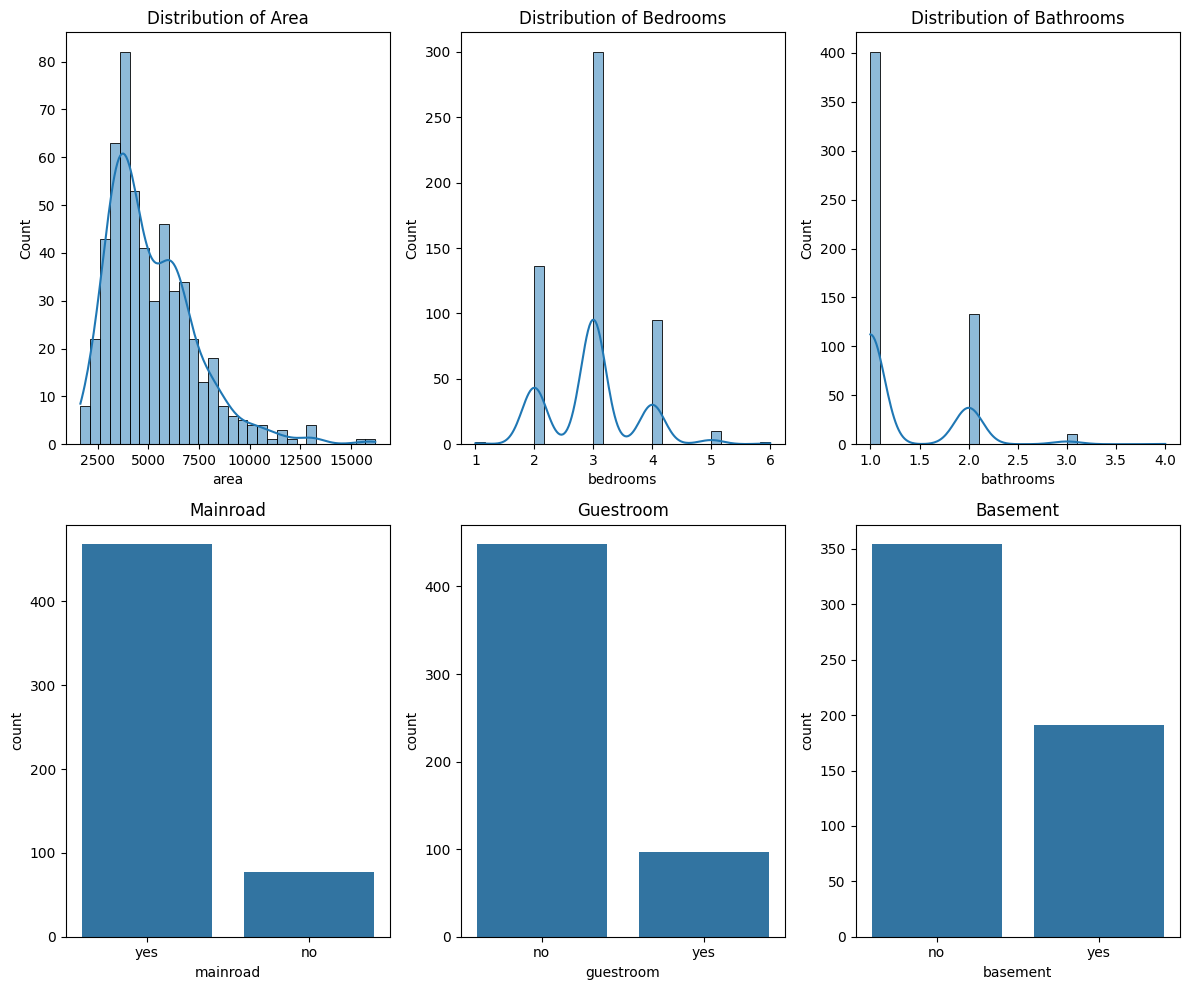

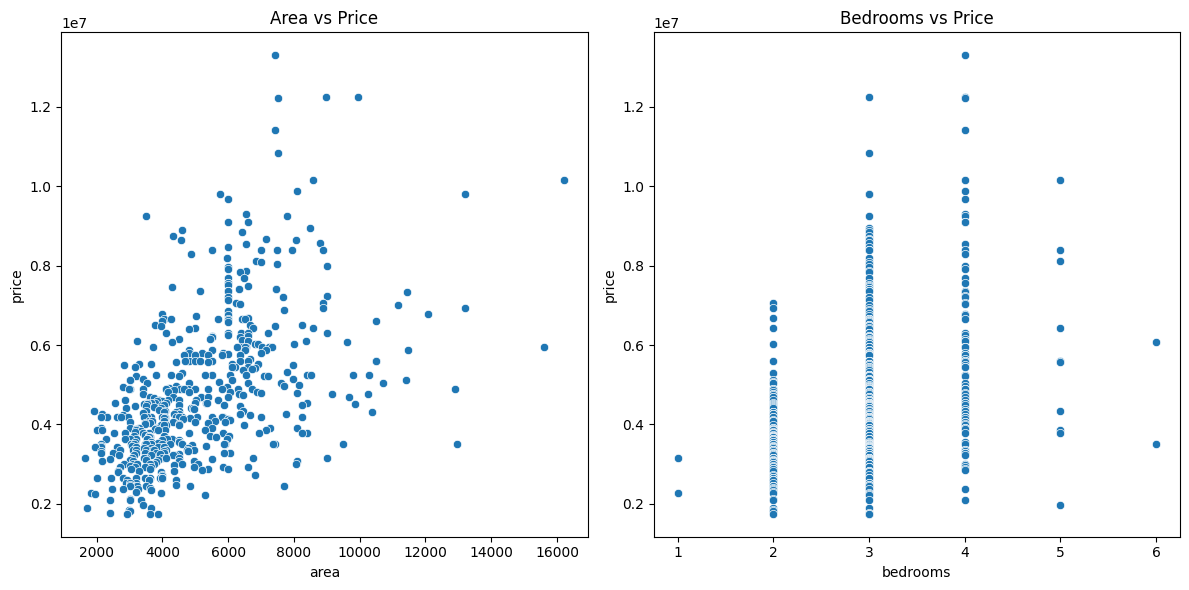

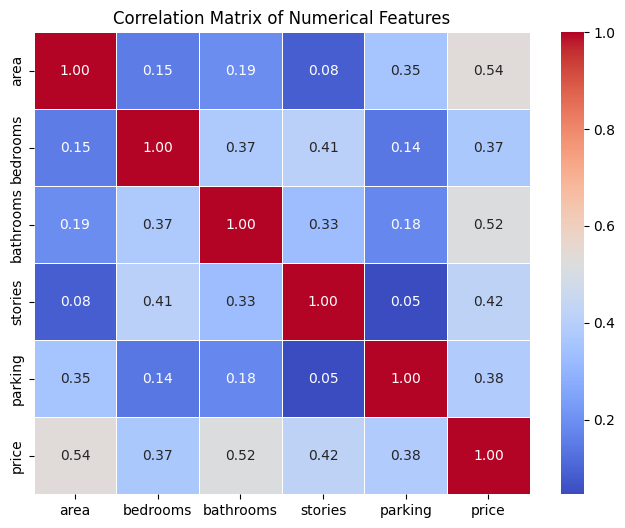

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the visualizations
plt.figure(figsize=(12, 10))

# 1. Histograms for numerical features (Area, Bedrooms, Bathrooms)
plt.subplot(2, 3, 1)
sns.histplot(data['area'], kde=True, bins=30)
plt.title('Distribution of Area')

plt.subplot(2, 3, 2)
sns.histplot(data['bedrooms'], kde=True, bins=30)
plt.title('Distribution of Bedrooms')

plt.subplot(2, 3, 3)
sns.histplot(data['bathrooms'], kde=True, bins=30)
plt.title('Distribution of Bathrooms')

# 2. Bar charts for categorical features
plt.subplot(2, 3, 4)
sns.countplot(x='mainroad', data=data)
plt.title('Mainroad')

plt.subplot(2, 3, 5)
sns.countplot(x='guestroom', data=data)
plt.title('Guestroom')

plt.subplot(2, 3, 6)
sns.countplot(x='basement', data=data)
plt.title('Basement')

plt.tight_layout()
plt.show()

# 3. Scatter plots for correlation between numerical features and target variable (price)
plt.figure(figsize=(12, 6))

# Scatter plot for Area vs Price
plt.subplot(1, 2, 1)
sns.scatterplot(x='area', y='price', data=data)
plt.title('Area vs Price')

# Scatter plot for Bedrooms vs Price
plt.subplot(1, 2, 2)
sns.scatterplot(x='bedrooms', y='price', data=data)
plt.title('Bedrooms vs Price')

plt.tight_layout()
plt.show()

# 4. Correlation matrix heatmap for numerical features
correlation_matrix = data[['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [4]:
# Separating features and target
X = data[categorical_columns + numerical_columns]
y = data[target_column]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# OneHotEncoding for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

# Building pipelines for models
models = {
    "Linear Regression": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    "Gradient Boosting": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    "AdaBoost": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    "Support Vector Regressor (SVR)": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR())
    ]),
    "Decision Tree": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeRegressor(random_state=42))
    ])
}

# Training and evaluating models
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[model_name] = {"MSE": mse, "R2": r2}

# Display results
print("Model Evaluation:")
for model_name, metrics in results.items():
    print(f"{model_name}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}")

# Hyperparameter tuning for Random Forest
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Number of trees
    'model__max_depth': [10, 20, 30, None],  # Maximum depth of the trees
    'model__min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'model__min_samples_leaf': [1, 2, 4]     # Minimum samples at a leaf node
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=models["Random Forest"],  # Random Forest pipeline
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score (negative MSE):", grid_search.best_score_)

# Use the best estimator for predictions
best_rf_model = grid_search.best_estimator_
tuned_predictions = best_rf_model.predict(X_test)

# Evaluate the tuned model
tuned_mse = mean_squared_error(y_test, tuned_predictions)
tuned_r2 = r2_score(y_test, tuned_predictions)

print(f"\nAfter Tuning: MSE = {tuned_mse:.2f}, R² = {tuned_r2:.2f}")

Model Evaluation:
Linear Regression: MSE = 1754318687330.67, R2 = 0.65
Random Forest: MSE = 1959323004717.27, R2 = 0.61
Gradient Boosting: MSE = 1688403924777.51, R2 = 0.67
AdaBoost: MSE = 2237444322297.88, R2 = 0.56
Support Vector Regressor (SVR): MSE = 5567929077615.07, R2 = -0.10
Decision Tree: MSE = 2642802637614.68, R2 = 0.48
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best Score (negative MSE): -1169287169970.3613

After Tuning: MSE = 2066175698215.50, R² = 0.59


Best Model: Gradient Boosting with R² = 0.67 and MSE = 1688403924777.51


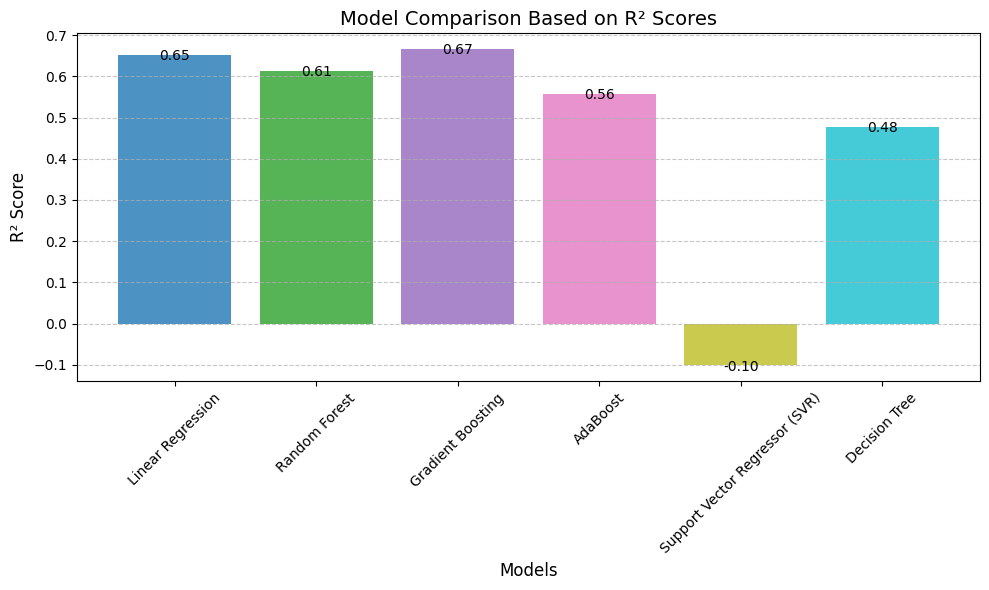

In [8]:
# Find the best model based on R2 score
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model_metrics = results[best_model_name]

# Print the best model
print(f"Best Model: {best_model_name} with R² = {best_model_metrics['R2']:.2f} and MSE = {best_model_metrics['MSE']:.2f}")

# Visualization of results
model_names = list(results.keys())
r2_scores = [results[model]["R2"] for model in model_names]
mse_scores = [results[model]["MSE"] for model in model_names]

# Set colors for each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_scores, color=colors, alpha=0.8)

# Annotate bars with their R2 scores
for bar, r2 in zip(bars, r2_scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - 0.02,  # Position slightly below top of the bar
        f"{r2:.2f}",
        ha='center', va='bottom', fontsize=10, color="black"
    )

# Add titles and labels
plt.title("Model Comparison Based on R² Scores", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


<ipython-input-9-bcd625d243a6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


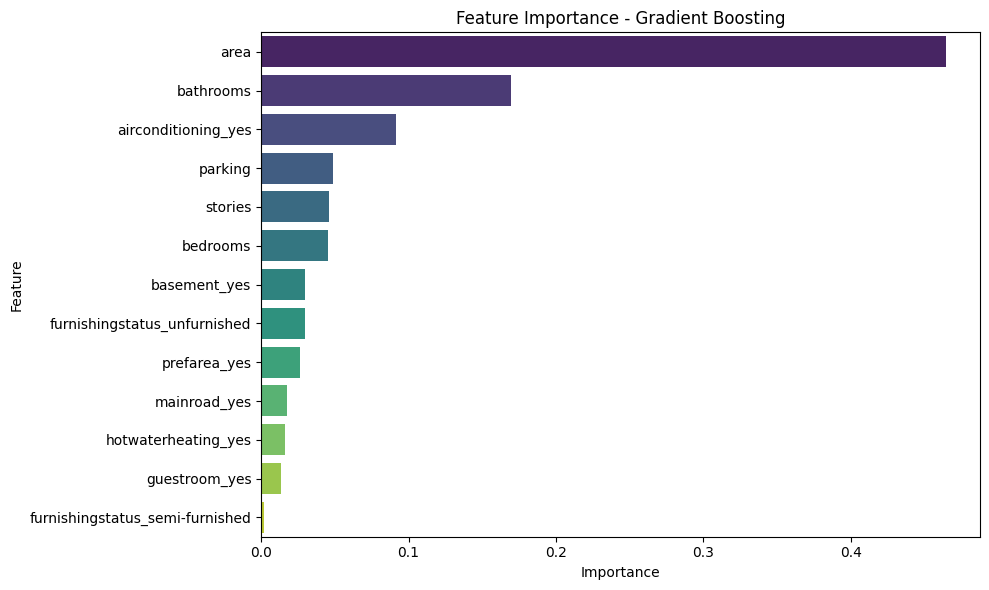

In [9]:
# Feature importance for Gradient Boosting
best_model = models["Gradient Boosting"]
gb_model = best_model.named_steps['model']

# Extracting feature importance
encoded_feature_names = numerical_columns + list(
    best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_columns)
)
feature_importances = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [10]:
feature_importances

,Feature,Importance
0,area,0.464321
2,bathrooms,0.169201
9,airconditioning_yes,0.091497
4,parking,0.048649
3,stories,0.045925
1,bedrooms,0.045333
7,basement_yes,0.029761
12,furnishingstatus_unfurnished,0.029653
10,prefarea_yes,0.026430
5,mainroad_yes,0.017484


In [11]:
def predict_house_price(model_pipeline):
    """
    we define a function to predict house price based on user inputs.
    """
    print("\nEnter the house details for prediction:")
    try:
        # User inputs
        area = float(input("Enter area in square feet: "))
        bedrooms = int(input("Enter number of bedrooms: "))
        bathrooms = int(input("Enter number of bathrooms: "))
        stories = int(input("Enter number of stories: "))
        mainroad = input("Is the house on a main road? (yes/no): ").strip().lower()
        guestroom = input("Does the house have a guest room? (yes/no): ").strip().lower()
        basement = input("Does the house have a basement? (yes/no): ").strip().lower()
        hotwaterheating = input("Does the house have hot water heating? (yes/no): ").strip().lower()
        airconditioning = input("Does the house have air conditioning? (yes/no): ").strip().lower()
        parking = int(input("Enter the number of parking spaces: "))
        prefarea = input("Is the house in a preferred area? (yes/no): ").strip().lower()
        furnishingstatus = input("Enter furnishing status (furnished/semi-furnished/unfurnished): ").strip().lower()

        # Creating a dataframe for user input
        user_data = pd.DataFrame({
            'area': [area],
            'bedrooms': [bedrooms],
            'bathrooms': [bathrooms],
            'stories': [stories],
            'mainroad': [mainroad],
            'guestroom': [guestroom],
            'basement': [basement],
            'hotwaterheating': [hotwaterheating],
            'airconditioning': [airconditioning],
            'parking': [parking],
            'prefarea': [prefarea],
            'furnishingstatus': [furnishingstatus]
        })

        # Predicting house price
        predicted_price = model_pipeline.predict(user_data)[0]
        print(f"\nThe predicted house price is: ${predicted_price:,.2f}")
    except Exception as e:
        print(f"Error in input or prediction: {e}")


# Train the best model (Gradient Boosting)
final_model = models["Gradient Boosting"]
final_model.fit(X_train, y_train)

# Allow user input for prediction
predict_house_price(final_model)



Enter the house details for prediction:
Enter area in square feet: 1500
Enter number of bedrooms: 5
Enter number of bathrooms: 3
Enter number of stories: 3
Is the house on a main road? (yes/no): yes
Does the house have a guest room? (yes/no): yes
Does the house have a basement? (yes/no): no
Does the house have hot water heating? (yes/no): no
Does the house have air conditioning? (yes/no): yes
Enter the number of parking spaces: 3
Is the house in a preferred area? (yes/no): yes
Enter furnishing status (furnished/semi-furnished/unfurnished): furnished

The predicted house price is: $6,763,750.63
